# MNIST Handwritten digit recognition with Watson Machine Learning GPUs
## From IBM Watson Studio Python Jupyter Notebook with ART toolbox

This tutorial shows IBM Watson Studio framework capabilities to train Keras on TensoFlow CNN models with GPU-enabled Watson Machine learning

The a Convolutional Neural Network (CNN) model is build & trained classically, and then improved in term of robustness & accuracy with IBM Watson Machine Learning Toolbox ART & IBM Watson ML capabilities.


## References
https://dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/ml_dlaas_e2e_example.html

## Environment Setup 
Install base Data Science libraries, including Keras.

We will use Keras to construct the CNN model and then send it to WML training subsystem for actual training.

#### Background information on WML Deep Learning with GPUs
https://dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/ml_dlaas_gpus.html

In [1]:
# Import base Data Science libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(num=None, figsize=(8, 6), dpi=100, facecolor='w', edgecolor='k')
%matplotlib inline

# Import Keras
import keras
print("Keras version :",keras.__version__)
from keras.models import load_model
import keras.backend as k
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from keras.optimizers import RMSprop

import warnings
warnings.resetwarnings() # Maybe somebody else is messing with the warnings system?
warnings.filterwarnings('ignore') # Ignore everything

Using TensorFlow backend.


Keras version : 2.2.4


### Define Image utility functions 
Utility functions to manipulate images

In [2]:
# Define a few utility functions

def setupSubPlots(numCols,maxRows):
    numRows=1+(maxRows-1)//numCols
    return plt.subplots(numRows,numCols,squeeze=False,figsize=(20,numRows/3*4))

def plotImage(img,axs,ix,numCols,title=None):
    ax=axs[ix//numCols][ix%numCols]
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if title: 
        ax.set_title(title)
        ax.set_xticks([])
    return ax.imshow(img.squeeze())

def showImages(imgTable, limit, numCols=15, legend=None):
    ''' Image plotting function, using a set number of columns
    '''
    limit=min(limit,len(imgTable))
    if limit<numCols: numCols=limit
    fig, axs = setupSubPlots(numCols,limit)
    for ix,img in enumerate(imgTable):
        if ix>=limit: break
        plotImage(img,axs,ix,numCols)
    if legend:
        fig.suptitle(legend, fontsize=16)
    return

def showImagesAccuracy(description,images, labels, predictions, maxShown=30, numCols=15):
    ''' Check Images prediction accuracy, count and display mismatches
    '''
    idx = 0
    errorsCount = 0
    shown = 0
    fig, axs = setupSubPlots(numCols,maxShown)
    for idx,img in enumerate(images):
        predicted = np.argmax(predictions[idx])
        actual = np.argmax(labels[idx])
        if predicted != actual:
            errorsCount += 1
            if shown < maxShown:
                # Plotting first samples of MNIST
                plotImage(img,axs,shown,numCols,"{}->{}".format(actual,predicted))
                shown += 1
    # Compute accuracy as a percentage         
    accuracy = (100-(errorsCount/len(images))*100)
    legend="{}\nSucccess rate: {:.2f}%".format(description,accuracy)
    print(legend)
    #fig.suptitle(legend)
    return accuracy

## MNIST data set utility loading code
This code is used to load the MNISt dataset and prepare it for Keras

##  Step 2 Load and prepare dataset for training
We will load pre-shuffled **MNIST** (*Modified National Institute of Standards and Technology*) HandWritten digits annotated data from the Keras datasets library.   

Note that we will not use the data directly for training from this notebook, only for displaying and sending out to WML training backend.

Also note that this is a replica of the Keras example as outlined at https://keras.io/examples/mnist_cnn/.

In [3]:
# Read MNIST dataset
from keras.datasets import mnist

# input image dimensions and number of labels (classes)
img_rows, img_cols = 28, 28
num_classes = 10

# Load the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if k.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

# Convert each pixel to value to float, normalized to 0-1 range
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255
#x_train /= 255
#x_test /= 255

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

print(f"There are {len(x_train)} images in the training set, and {len(x_test)} in the test set of shape {x_train.shape}")

There are 60000 images in the training set, and 10000 in the test set of shape (60000, 28, 28, 1)


### Show the first 30 images on 15 columns
We use one the functions defined above to get an idea of how the images from the MNIST dataset look like

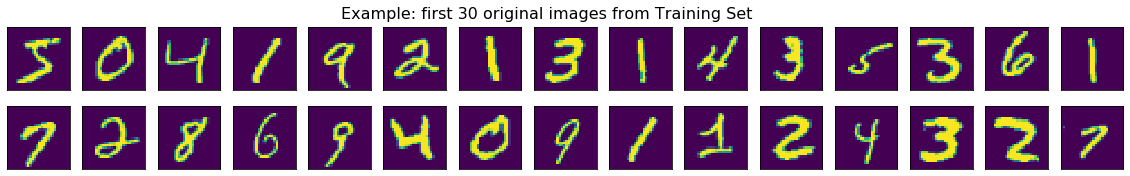

In [4]:
# Show first thirty images from the training set
showImages(x_train,30,15,"Example: first 30 original images from Training Set")

## Step3: Create Keras convolutional neural network
This uses a basic CNN architecture from the Keras example at https://keras.io/examples/mnist_cnn/
The model layers are added sequentially:

**[Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D)**
    It is a 2D convolutional layer that we use to process the 2D MNIST input images:
    * The first argument passed to the Conv2D() layer function is the number of output channels – in this case we have 32 output channels. 
    * `kernel_size`, is the size of the sampling moving window, here a 3x3 aperture
    * the activation function is a rectified linear unit (ReLU) 
    * The shape (size: height, width, color depth) of the input is inferred from the training set image size.
    Noe that declaring the input shape is only required of the first layer, Keras will then work out the size of the tensors flowing through the model (automatic shape inference). We start with 26x26 pixels and 32 bit colors

**[MaxPool2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D)**:
    Reduction matrix, here we halve each dimension, resulting shape will be a 13x13x32 matrix

**[Flatten](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten)**:
    Transform the input's shape n*c*h*w into a n*(c*h*w) vector) yields 13*13*32=5408 outputs as a flat vector

**[Dense(128,relu)](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense)**:
    A layer where each neuron is linked to each ones of the next layer. This layer is set to yield 128 outputs

**[DropOut](https://www.tensorflow.org/api_docs/python/tf/keras/layers/DropOut)**:
    Freeze some neurons to avoid overfitting. *Dropout consists in randomly setting a fraction rate of input units to 0 at each update during training time, which helps prevent overfitting.*

**[Dense(10,SoftMax)]**
    Layer to transform a scoring distribution into a probability distribution, with 10 outputs for our 10 digits. *The [softmax](https://www.tensorflow.org/api_docs/python/tf/keras/activations/softmax) function normalizes ('squashes') a K-dimensional vector of real values to a K-dimensional vector of real values, where each entry is in the range (0, 1),[a] and all the entries add up to 1.

**Optimizer parameters**:
    * lr: Learning rate, interval used for the gradient descent algorithm
    * **[loss]()**: Cost/loss function used for this neural network, here we use *Categorical cross entropy*

In [5]:
# Create Keras convolutional neural network - basic architecture from Keras examples
# In this cell, we build the model structure, but we do not trainit yet
k.set_learning_phase(1) # training

model = Sequential()
model.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=x_train.shape[1:]))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(10, activation='softmax'))

# Set Hyperparameters
Optimizer='adam'
#Optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

# Initialize and compile:
model.compile(optimizer=Optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


After construction, we display a summary of our ANN model as shown in the cell result above.   

Note the total number of weights & bias to be determined during the training sequence and understand how complex can be to train very complex ANN with hundreds of layers.
Here we have 3 layers amounting to 320 + 692352 + 1290 = 693962 parameters.

In [6]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 5408)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               692352    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1290      
Total params: 693,962
Trainable params: 693,962
Non-trainable params: 0
_________________________________________________________________


## Model training in Watson machine Learning

We will now prepare the context to send the untrained model to WML for training.   
To this effect, we will upload several artifacts to a Cloud Object Storage bucket:
1. 

### Gathering COS and WML credentials

We will need to obtain credentials to interact with the IBMClLoud COS and WML services:
1. Switch back to the IBMCloud account management using the hamburger menu at the top left corner: 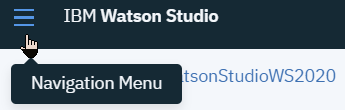
2. Select the Resource List menu 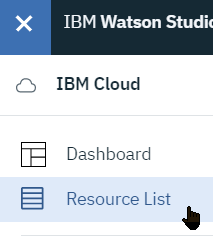 (open it in a separate tab using Ctrl-Shift key)
3. Expand the Storage tab to Locate your Cloud Object Storage instance: 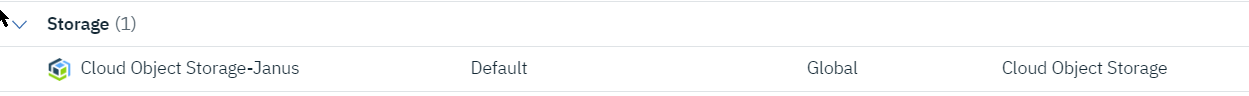, and click to open it
4. Select Service Credentials and the `[new credential (+)]` button 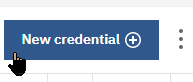
5. Modify the name to e.g. `COS Service credentials-Keras MNIST NB`, check the `Include HMAC Credential` and click `[Add]` button 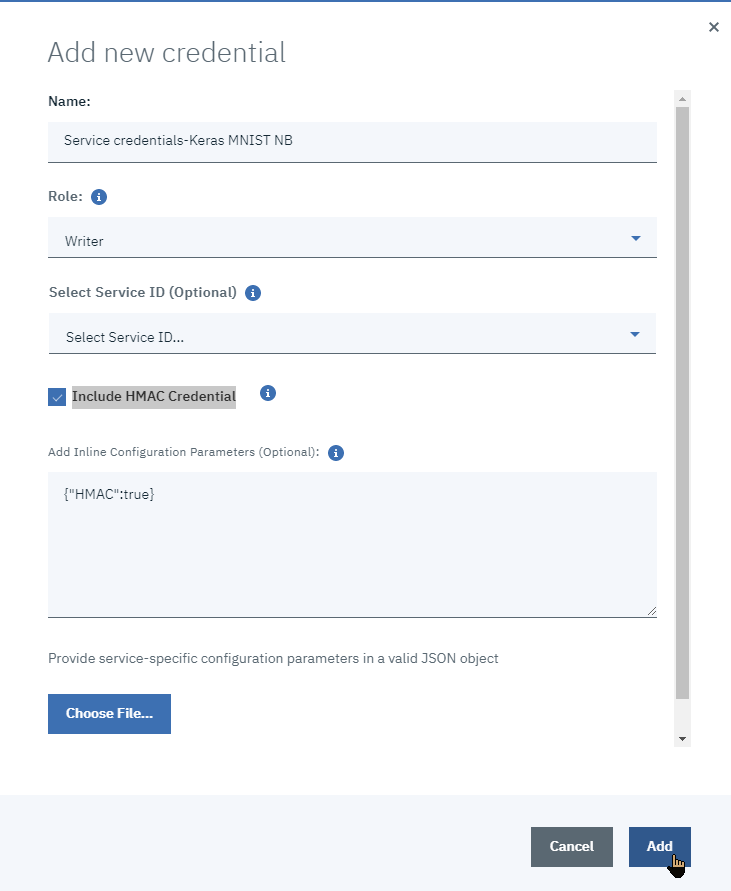
6. View the newly creatde credentials and copy them to clipboard 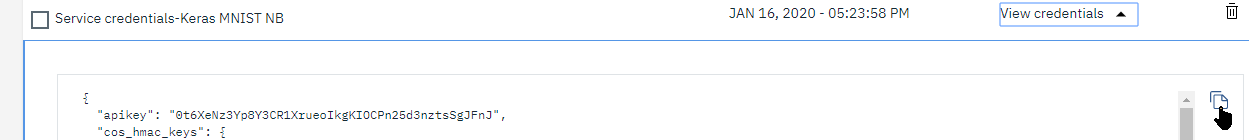
7. Finally, replace the credentials in the code cell below

In [7]:
cos_credentials = {
  "apikey": "0t6XeNz3Yp8Y3CR1XrueoIkgKIOCPn25d3nztsSgJFnJ",
  "cos_hmac_keys": {
    "access_key_id": "c1ea6c0fd408467a8ba06aed8e6dfe67",
    "secret_access_key": "26487e81a3df6e042465c495fd328765d53b50691b2afa77"
  },
  "endpoints": "https://control.cloud-object-storage.cloud.ibm.com/v2/endpoints",
  "iam_apikey_description": "Auto-generated for key c1ea6c0f-d408-467a-8ba0-6aed8e6dfe67",
  "iam_apikey_name": "Service credentials-Keras MNIST NB",
  "iam_role_crn": "crn:v1:bluemix:public:iam::::serviceRole:Writer",
  "iam_serviceid_crn": "crn:v1:bluemix:public:iam-identity::a/916b74438d744ae9a9abc7948731692c::serviceid:ServiceId-17c9ae8b-663a-4c00-9e30-7731c807dea1",
  "resource_instance_id": "crn:v1:bluemix:public:cloud-object-storage:global:a/916b74438d744ae9a9abc7948731692c:3ab464fa-2a6c-4b3d-b326-6f809c3b27fd::"
}

### Gather WML credentials
Similarly, from the IBMCloud Resources list:
1. locate your `Machine Learning` instance in the `Services` section 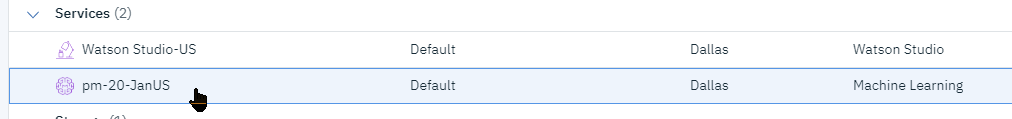
2. Create a new credential, this time name it e.g. `WML Service credentials-Keras MNIST NB`, and create a new `Serviceid` named e.g. `WML Serviceid-Keras MNIST NB` 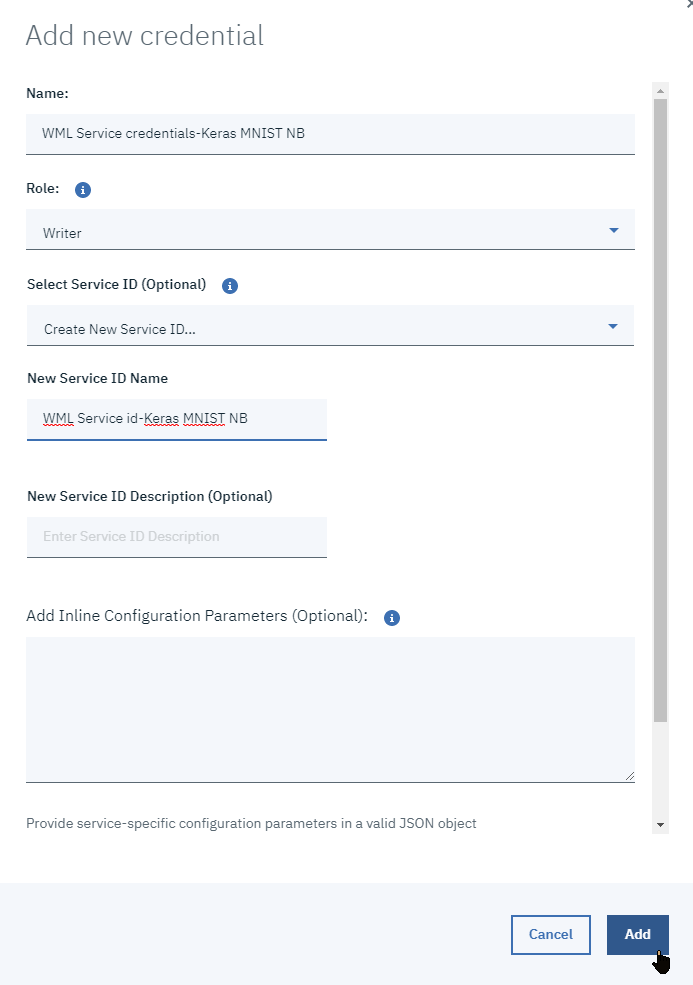
3. Expand the newly create credentials, copy to clipboard and paste them in the code cell below

In [8]:
wml_credentials = {
  "apikey": "PU8r4v_RfihDEZ0KRfblzIObdxkt9kFapzLkt5_reFEl",
  "iam_apikey_description": "Auto generated apikey during resource-key operation for Instance - crn:v1:bluemix:public:pm-20:us-south:a/916b74438d744ae9a9abc7948731692c:b56805ef-6249-4925-8876-044f9b42e446::",
  "iam_apikey_name": "auto-generated-apikey-f9524322-be27-43db-8a88-5491e0bf83b5",
  "iam_role_crn": "crn:v1:bluemix:public:iam::::serviceRole:Writer",
  "iam_serviceid_crn": "crn:v1:bluemix:public:iam-identity::a/916b74438d744ae9a9abc7948731692c::serviceid:ServiceId-1b2d4ed4-339a-40b2-9acc-c8623aa9559e",
  "instance_id": "b56805ef-6249-4925-8876-044f9b42e446",
  "url": "https://us-south.ml.cloud.ibm.com"
}

## Upload training set and model to COS for use by WML
The code cells below create a COS context to access our COS instance

We will first determine the COS direct endpoint URL which is in the same data center as the WML instance

In [9]:
# Note that the service endpoint is where the buckets will be created, selecting a region close to the WML instance will be more efficient
#region='us-south'
import re
region=re.findall(r"https://(.*?)\..*",wml_credentials['url'])[0]

# direct endpoints remain internal to the IBMCloud network
import requests
r=requests.get(cos_credentials['endpoints'])
r.raise_for_status()
service_endpoint_url = "https://"+r.json().get('service-endpoints').get('regional').get(region).get('direct').get(region)
print(f"Selecting endpoint for region {region}: {service_endpoint_url}")

Selecting endpoint for region us-south: https://s3.direct.us-south.cloud-object-storage.appdomain.cloud


In [10]:
# Now create cos resource
import ibm_boto3
from ibm_botocore.client import Config
auth_endpoint = 'https://iam.bluemix.net/oidc/token'
cos = ibm_boto3.resource('s3',
     ibm_api_key_id=cos_credentials['apikey'],
     ibm_service_instance_id=cos_credentials['resource_instance_id'],
     ibm_auth_endpoint=auth_endpoint,
     config=Config(signature_version='oauth'),
     endpoint_url=service_endpoint_url)

In [11]:
# This is the base name on which to create all names (must be lowercase)
trainingName='kerasmnist'

### Preventive Clean-up
To avoid cluttering our COS with left-over buckets from previous runs, we will remove all the buckets starting with our prefix

In [13]:
# this cell is used to clean-up COS buckets
coscl=cos.meta.client
bucketPrefix=f'{trainingName}-'
bucketNames=[x['Name'] for x in coscl.list_buckets()['Buckets'] if (x['Name'].startswith(bucketPrefix) and not 'donotdelete' in x['Name'])]
print(f"Found {len(bucketNames)} buckets to delete")
for bucketName in bucketNames:
    objs=coscl.list_objects(Bucket=bucketName)
    if 'Contents' in objs.keys():
        objKeys=[{'Key' : obj['Key']} for obj in objs['Contents']]
        print(f"Deleting {len(objKeys)} objects from {bucketName}")
        [print(f"\t{k}") for k in objKeys]
        objKeys=[{'Key' : obj['Key']} for obj in objs['Contents']]
        coscl.delete_objects(Bucket=bucketName,Delete={'Objects': objKeys})
        pass
    print(f"Deleting bucket {bucketName}")
    coscl.delete_bucket(Bucket=bucketName)

Found 0 buckets to delete


## Set-up access to WML instance
We will now setup the WML access and display some statistics and facts on this account

Note that lite accounts can have access to only k80 GPUs while regular accounst can also have V100s

In [14]:
import watson_machine_learning_client as WMLClient
wml = WMLClient.WatsonMachineLearningAPIClient(wml_credentials)

2020-01-21 22:36:08,163 - tensorflow - WARNING - From /opt/conda/envs/Python36/lib/python3.6/site-packages/tensorflow/python/ops/math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.
2020-01-21 22:38:48,748 - watson_machine_learning_client.wml_client_error - WARNING - Deployment creation failed. Error: 402. {"trace":"ad1926e1e63dd223bd8f75a8cc793524","errors":[{"code":"deployments_plan_limit_reached","message":"Current plan 'lite' only allows 5 deployments"}]}
2020-01-21 22:41:47,894 - watson_machine_learning_client.wml_client_error - WARNING - Invalid set artifact_type: {'definition': False, 'model': False, 'experiment': False, 'function': False, 'runtime': False, 'library': False, 'deployment': False}


In [15]:
import pprint
print(f"WML client version {wml.version}. Some supported frameworks:")
for f in wml.training.get_frameworks()['frameworks']:
    print(f"\t{f['name']}\tv{f['version']}\t{f.get('runtimes')}")
details=wml.service_instance.get_details().get('entity')
#pprint.pprint(details)
for u,v in details.get('usage').items():
    if isinstance(v, dict):
        current=v.get('current')
        limit=v.get('limit')
        percent=0 if limit==0 else (current*100)/limit
        print(f"{u:20}:\t{current:10} /{limit:10} - {percent:.2f} %")
    else:
        print(f"{u:20}: {v}")

WML client version 1.0.378. Some supported frameworks:
	scikit-learn	v0.17	None
	pytorch	v0.3	[{'name': 'python', 'version': '3.6'}]
	caffe	v1.0	[{'name': 'python', 'version': '3.5'}]
expiration_date     : 2020-02-01T00:00:00.000Z
computation_time    :	         0 /1800000000 - 0.00 %
gpu_count_k80       :	         0 /         8 - 0.00 %
model_count         :	         9 /       200 - 4.50 %
gpu_count_p100      :	         0 /         0 - 0.00 %
prediction_count    :	       463 /   1000000 - 0.05 %
capacity_units      :	  13821796 /1800000000 - 0.77 %
deployment_count    :	         6 /         5 - 120.00 %
gpu_count_v100      :	         0 /         0 - 0.00 %


### Clean-up WML past trainings
Similarly, we will now use the WML API to clean-up previous training and definitions with the name

In [ ]:
# Clean-up past trainings named with our prefix
trainings=wml.training.get_details()['resources']
print(f"There are {len(trainings)} trainings in total, cleaning-up trainings with name {trainingName}")

import pprint
for t in trainings:
    if t['entity']['model_definition']['name']==trainingName:
        print(f"Deleting training: {t['entity']['model_definition']['name']} with guid={t['metadata']['guid']}")
        r=wml.training.delete(t['metadata']['guid'])
        if r=='FAILED': 
            pprint.pprint(r)
            pprint.pprint(t)

## Prepare WML boilerplate training code
The following cell will write out its contant to a file, using the `%%writefile` cell magic

This Python source file will then be sent to WML through COS storage for execution of the training phase

In [17]:
%%writefile wmlKerasModelTrainer.py

#from keras.layers import Dense, Dropout, Flatten, Input, Reshape
#from keras.layers.advanced_activations import LeakyReLU
#from keras.models import Model, Sequential
#from keras.optimizers import adam
#from numpy import add, expand_dims, ones, prod, zeros
#from numpy.random import normal, randint
#from subprocess import call
#from sys import executable, stdout

import numpy as np
print("numpy version :",np.__version__)

import keras
print("Keras version :",keras.__version__)

def loadModel(model_file):
    # Import Keras
    from keras.models import load_model

    import warnings
    warnings.resetwarnings() # Maybe somebody else is messing with the warnings system?
    warnings.filterwarnings('ignore') # Ignore everything
    
    # Get model from file system
    print(f"Loading model from file {model_file}")
    model=keras.models.load_model(model_file)
    model.summary()

    return model

def saveModel(model,model_name,scores,y_predict,model_path):
    model_file=f"{model_path}/{model_name}_model.hdf5"
    print(f"Storing trained model into {model_file}")
    model.save(model_file)
    
    # Save prediction to COS result bucket
    predict_file=f"{model_path}/../{model_name}_predict.npz"
    print(f"Storing scores and predicted data using numpy version {np.__version__} into {predict_file}")
    with open(predict_file,'wb') as data_file:
        np.savez(data_file,scores=scores,y_predict=y_predict)
    
def loadData(DATA_DIR,model_name,data_type):
    data_file = os.path.join(DATA_DIR, f"{model_name}_{data_type}.npz")    
    print(f"Loading {data_type} data from file {data_file}")
    with np.load(data_file,allow_pickle=True) as np_data:
        return (np_data['x_data'],np_data['y_data'])

def fitModel(model,train_data,verbose,epochs,batch_size):
    # Load training data from train_file    
    (x_train,y_train)=train_data
    
    print(f"Starting training of model with {len(x_train)} elements")
    fitResult=model.fit(x_train,y_train,verbose=verbose,epochs=epochs,batch_size=batch_size)
    print(f"Model training complete")
    
    # return the now-trained model
    return fitResult

def testModel(model,test_data):
    ## Now test data
    (x_test,y_test)=test_data
    print(f"Testing with {len(x_test)} items")
    scores = model.evaluate(x_test, y_test, verbose=1)
    print("Baseline Error: %.2f%%" % (100-scores[1]*100))
    
    ## predict the values on the test set
    y_predict=model.predict(x_test)
    
    return scores,y_predict
        
if __name__ == '__main__':
    print('Entering main!')
    from argparse import ArgumentParser
    parser = ArgumentParser()

    parser.add_argument('--data_dir', type=str, default='$DATA_DIR',help='Directory with data')
    parser.add_argument('--result_dir', type=str, default='$RESULT_DIR',help='Directory with results')
    parser.add_argument('--model_name', type=str, default='*.hdf5',help='Name of model')
    parser.add_argument('--epochs', type=int, default=10,help='Number of training iterations')
    parser.add_argument('--batch_size', type=int, default=128,help='Size of the batch')
    parser.add_argument('--verbose', type=int, default=2,help='0 = silent, 1 = progress bar, 2 = one line per epoch')

    FLAGS, unparsed = parser.parse_known_args()
    print(f"Parsed arguments FLAGS={FLAGS} unparsed={unparsed}")

    # Create directories
    import os, sys
    from shutil import rmtree
    if (FLAGS.result_dir[0] == '$'):
        RESULT_DIR = os.environ[FLAGS.result_dir[1:]]
    else:
        RESULT_DIR = FLAGS.result_dir

    model_path = os.path.join(RESULT_DIR, 'model')
    try:
        os.makedirs(model_path)
    except FileExistsError:
        shutil.rmtree(model_path)
        os.makedirs(model_path)

    if (FLAGS.data_dir[0] == '$'):
        DATA_DIR = os.environ[FLAGS.data_dir[1:]]
    else:
        DATA_DIR = FLAGS.data_dir

    # Find the model in the training data dir
    print(f"Loading model {FLAGS.model_name}")
    model_file=os.path.join(DATA_DIR, f'{FLAGS.model_name}_model.hdf5')

    # Now process the loaded model
    model=loadModel(model_file)

    # Find the training data in the training dir and train/fit model
    train_data=loadData(DATA_DIR,FLAGS.model_name,'train')
    print(f"Training model {FLAGS.model_name}")
    fitModel(model,train_data,FLAGS.verbose,FLAGS.epochs,FLAGS.batch_size)

    # Find the test data in the training dir and test model
    test_data=loadData(DATA_DIR,FLAGS.model_name,'test')
    print(f"Testing model {FLAGS.model_name}")
    scores,y_predict=testModel(model,test_data)
    
    # Save the model and predictions in return
    saveModel(model,FLAGS.model_name,scores,y_predict,model_path)
    
    print('Training of model done!')
    sys.stdout.flush()

Writing wmlKerasModelTrainer.py


## Create a wrapper function to execute the training on WML
The function below is responsible for packaging the Keras model and setting up WML to run the `fit()` training method on WML

In [18]:
import watson_machine_learning_client.metanames as WMLMeta

trainingRunner='wmlKerasModelTrainer'

def storeModelDefinition(wmlClientRepo,modelName,epochs,batch_size):
    # zip the code of the python executor boilerplate
    !zip {trainingRunner}.zip {trainingRunner}.py
    
    # Store model definition in WML, define metadata
    model_definition_metadata = {
        WMLMeta.ModelDefinitionMetaNames.NAME: modelName,
        WMLMeta.ModelDefinitionMetaNames.DESCRIPTION: f"{modelName}-definition",
        WMLMeta.ModelDefinitionMetaNames.AUTHOR_NAME: f"{modelName}-author",
        WMLMeta.ModelDefinitionMetaNames.FRAMEWORK_NAME: 'tensorflow',
        WMLMeta.ModelDefinitionMetaNames.FRAMEWORK_VERSION: '1.14',
        WMLMeta.ModelDefinitionMetaNames.RUNTIME_NAME: 'python',
        WMLMeta.ModelDefinitionMetaNames.RUNTIME_VERSION: '3.6',
        #WMLMeta.ModelDefinitionMetaNames.FRAMEWORK_LIBRARIES: [{'name':'keras', 'version': '2.1.6'}],
        #WMLMeta.ModelDefinitionMetaNames.FRAMEWORK_LIBRARIES: [{'name':'keras', 'version': keras.__version__}],
        WMLMeta.ModelDefinitionMetaNames.EXECUTION_COMMAND: f"python3 {trainingRunner}.py --model_name {modelName} --epochs {epochs} --batch_size {batch_size}"
    }
    definition_details = wmlClientRepo.store_definition(f"{trainingRunner}.zip", model_definition_metadata)
    definition_uid = wmlClientRepo.get_definition_uid(definition_details)
    return definition_uid

# Setup the COS buckets for the input and output of the WML model training
def createWMLInOutBuckets(cosClient,modelName,bucket_uid):
    # Generate a pair of UUIDs to makeup the COS bucket names
    bucketNames = [f"{modelName}-training-{d}-{bucket_uid}"[0:62] for d in ['data','results']]
    buckets=[]
    for bucketName in bucketNames:
        if not cosClient.Bucket(bucketName) in cosClient.buckets.all():
            print(f"Creating bucket {bucketName}...")
            try:
                buckets.append(cosClient.create_bucket(Bucket=bucketName))
            except ibm_boto3.exceptions.ibm_botocore.client.ClientError as exc:
                print('Error: {}.'.format(exc.response['Error']['Message']))
                raise
    return buckets

def storeDatatoCOS(bucket,model_name,data_type,x_data,y_data):
    # Store the training data into COS data bucket
    print(f"Storing {data_type} data as npz file using numpy version {np.__version__}")
    with open(f"{model_name}_{data_type}.npz",'wb') as data_file:
        np.savez(data_file,x_data=x_data,y_data=y_data)
        #!ls -l
        bucket.upload_file(data_file.name,data_file.name)
        
def loadResultsfromCOS(bucket,training_guid,model_name):
    """
    Returns the results, e.g. a tuple with model, scores, y_predict
    """
    # Store the training data into COS data bucket
    import json
    training_output=json.loads(bucket.Object(f"{training_guid}/training-output.json").get()['Body'].read().decode('utf-8'))['training_output']
    
    model_file=f'{model_name}_model.hdf5'
    print(f"Loading trained model from {training_output}/model/{model_file}")
    bucket.download_file(f"{training_output}/model/{model_file}",model_file)
    from keras.models import load_model
    trained_model= load_model(model_file)
    
    predict_file=f"{model_name}_predict.npz"
    print(f"Loading predictions from {training_output}/{predict_file} using numpy version {np.__version__}")
    bucket.download_file(f"{training_output}/{predict_file}",predict_file)
    with np.load(predict_file,allow_pickle=True) as np_predict:
        return trained_model,np_predict['scores'],np_predict['y_predict']
   
def storeModeltoCOS(modelName,bucket):
    # Store the model file definition into COS data bucket
    print(f"Storing model as hdf5 file using keras version {keras.__version__}")
    modelFile=f'{modelName}_model.hdf5'
    model.save(modelFile)
    bucket.upload_file(modelFile,modelFile)

def trainModelInWML(wmlClient,modelName,buckets,cosClient,cos_credentials,definition_uid,computeConfig):
    # Configure the training metadata for the TRAINING_DATA_REFERENCE and TRAINING_RESULTS_REFERENCE.
    training_configuration_metadata = {
        WMLMeta.TrainingConfigurationMetaNames.NAME: modelName, 
        WMLMeta.TrainingConfigurationMetaNames.DESCRIPTION: f"{modelName}-definition",
        WMLMeta.TrainingConfigurationMetaNames.AUTHOR_NAME: f"{modelName}-author",            
        WMLMeta.TrainingConfigurationMetaNames.COMPUTE_CONFIGURATION: {'name': computeConfig},
        WMLMeta.TrainingConfigurationMetaNames.TRAINING_DATA_REFERENCE: {
            'type': cosClient.meta.service_name,
            'connection': {
                'endpoint_url': cosClient.meta.client.meta.endpoint_url,
                'access_key_id': cos_credentials['cos_hmac_keys']['access_key_id'],
                'secret_access_key': cos_credentials['cos_hmac_keys']['secret_access_key']
            },
            'source': {
                'bucket': buckets[0].name
            }
        },
        WMLMeta.TrainingConfigurationMetaNames.TRAINING_RESULTS_REFERENCE: {
            'type': cosClient.meta.service_name,
            'connection': {
                'endpoint_url': cosClient.meta.client.meta.endpoint_url,
                'access_key_id': cos_credentials['cos_hmac_keys']['access_key_id'],
                'secret_access_key': cos_credentials['cos_hmac_keys']['secret_access_key']
            },
            'target': {
                'bucket': buckets[1].name
            }
            
        }
    }
    
    training_run_details = wmlClient.training.run(definition_uid, training_configuration_metadata)
    print(f'Training running with UUID {training_run_details}')
    import pprint
    pprint.pprint(training_run_details)
    return training_run_details
    
def fit_WML(wmlClient,cosClient,cos_credentials,modelName,model,x_train,y_train,x_test=None,y_test=None,validation_split=0.2,computeConfig='k80',epochs=10,batch_size=128):
    definition_uid=storeModelDefinition(wmlClient.repository,modelName,epochs,batch_size);
    
    buckets=createWMLInOutBuckets(cosClient,modelName,definition_uid)

    # Store the model file to COS
    storeModeltoCOS(modelName,buckets[0])
    
    # if not split yes, generate test and train sets
    if validation_split and not ((y_test is None) or (x_test is None)):
        train_size=int(len(x_train)*(1-validation_split))
        x_test=x_train[train_size:]
        x_train=x_train[:train_size]
        y_test=y_train[train_size:]
        y_train=y_train[:train_size]

    # Store the training data into COS data bucket
    storeDatatoCOS(buckets[0],modelName,'train',x_train,y_train)
    
    # Store the training data into COS data bucket
    storeDatatoCOS(buckets[0],modelName,'test',x_test,y_test)
        
    # Kick-off the training run
    training_run_details=trainModelInWML(wmlClient,modelName,buckets,cosClient,cos_credentials,definition_uid,computeConfig)
    
    # Get training run initial status.
    import pprint
    training_run_guid_async = wmlClient.training.get_run_uid(training_run_details)
    status = wmlClient.training.get_status(training_run_guid_async)
    pprint.pprint(status, indent=2)
    
    # Monitor the logs for training
    wmlClient.training.monitor_logs(training_run_guid_async)
    
    # download the predictions
    trained_model,scores,y_predict=loadResultsfromCOS(buckets[1],training_run_details['metadata']['guid'],modelName)
        
    return (training_run_details,trained_model,scores,y_predict,buckets[1])

## run the training on WML
The following code cell will use the above defined method to kick-off the training of the model on WML

In [19]:
(training_run_details,trained_model,scores,y_predict,bucketResults)=fit_WML(wml,cos,cos_credentials,trainingName,model,x_train,y_train,x_test,y_test)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))

  adding: wmlKerasModelTrainer.py (deflated 66%)
Creating bucket kerasmnist-training-data-3c832d0a-548e-4c92-a0c1-e1e96abe7f17...
Creating bucket kerasmnist-training-results-3c832d0a-548e-4c92-a0c1-e1e96abe7f...
Storing model as hdf5 file using keras version 2.2.4
Storing train data as npz file using numpy version 1.15.4
Storing test data as npz file using numpy version 1.15.4
Training running with UUID {'entity': {'model_definition': {'definition_href': 'https://us-south.ml.cloud.ibm.com/v3/ml_assets/training_definitions/3c832d0a-548e-4c92-a0c1-e1e96abe7f17', 'description': 'kerasmnist-definition', 'execution': {'command': 'python3 wmlKerasModelTrainer.py --model_name kerasmnist --epochs 10 --batch_size 128', 'compute_configuration': {'name': 'k80'}}, 'framework': {'name': 'tensorflow', 'version': '1.14'}, 'name': 'kerasmnist'}, 'status': {'current_at': '2020-01-21T22:32:45.754Z', 'metrics': [], 'state': 'pending', 'submitted_at': '2020-01-21T22:32:45.754Z'}, 'training_data_reference'

## Display some of the wrongly predicted images

Showing first 30 test images that are wrongly classified by Keras classifier, and actual->predicted
Succcess rate: 10.25%


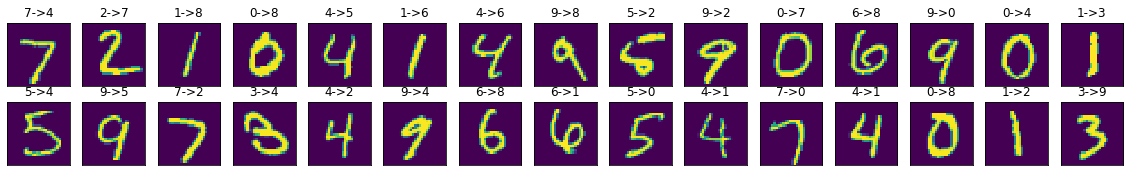

In [20]:
AccOriOri = showImagesAccuracy('Showing first 30 test images that are wrongly classified by Keras classifier, and actual->predicted',x_test, y_test, y_predict, 30)

## Store the trained model in WML for Deployment

In [24]:
training_run_guid=wml.training.get_run_uid(training_run_details)
stored_model_details = wml.repository.store_model( training_run_guid, trainingName )
model_uid            = wml.repository.get_model_uid( stored_model_details )
print( "Stored model_uid: ", model_uid )

Stored model_uid:  9f14f000-5ec6-4e0b-a083-f416694a8353


## Deploy as a REST API endpoint

In [25]:
deployment       = wml.deployments.create( model_uid, f"{trainingName}_REST", f"Online deployment of {trainingName} model" )
scoring_url = wml.deployments.get_scoring_url( deployment )
print("scoring_url: ", scoring_url )



#######################################################################################

Synchronous deployment creation for uid: '9f14f000-5ec6-4e0b-a083-f416694a8353' started

#######################################################################################


INITIALIZING
DEPLOY_IN_PROGRESS
DEPLOY_SUCCESS


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='09cf6076-052b-4abd-a7d8-d3a740a302b7'
------------------------------------------------------------------------------------------------


scoring_url:  https://us-south.ml.cloud.ibm.com/v3/wml_instances/b56805ef-6249-4925-8876-044f9b42e446/deployments/09cf6076-052b-4abd-a7d8-d3a740a302b7/online


## Score through the REST API endpoint
We will now use the endpoint to score a subset of our data and display the results

In [26]:
# Score 10 first digits
predictions = wml.deployments.score(scoring_url, {'values': x_test[0:10].tolist()})
print(f"Predictions: {[p[1] for p in predictions['values']]} ")
print(f"Actuals:     {[np.where(np.array(z) == 1.0)[0][0] for z in y_test[0:10].tolist()]} ")

#pprint.pprint(predictions['values'])

Predictions: [7, 2, 1, 0, 4, 1, 4, 9, 5, 9] 
Actuals:     [7, 2, 1, 0, 4, 1, 4, 9, 5, 9] 
